In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from cvxopt import matrix, solvers
from scipy.optimize import minimize

In [2]:
# Read data into pandas
japan = pd.read_excel(".././data/Price History_EWJ_Japan_Equity.xlsx")
t_bills_7_10 = pd.read_excel(".././data/Price History_7-10_US_TBills.xlsx")
t_bills_20 = pd.read_excel(".././data/Price History_20+_US_TBills.xlsx")
apac_x_japan = pd.read_excel(".././data/Price History_EPP_APACxJapan_Equity.xlsx")
europe = pd.read_excel(".././data/Price History_IEV_Europe_Equity.xlsx")
latam = pd.read_excel(".././data/Price History_ILF_LatAm_Equity.xlsx")
us = pd.read_excel(".././data/Price History_IVV_US_Equity.xlsx")
gold = pd.read_excel(".././data/Price History_IAU_Gold_Trust.xlsx")

In [3]:
def preprocess_and_rename(df, name):
    df['Exchange Date'] = pd.to_datetime(df['Exchange Date'])
    df.set_index('Exchange Date', inplace=True)
    df.rename(columns={'%Chg':f'Return {name}'}, inplace=True)
    return df[[f'Return {name}']]

# Preprocess all datasets and rename columns
japan = preprocess_and_rename(japan, 'Japan')
t_bills_7_10 = preprocess_and_rename(t_bills_7_10, 'T-Bills_7_10')
t_bills_20 = preprocess_and_rename(t_bills_20, 'T-Bills_20')
apac_x_japan = preprocess_and_rename(apac_x_japan, 'APACxJapan')
europe = preprocess_and_rename(europe, 'Europe')
latam = preprocess_and_rename(latam, 'LatAm')
us = preprocess_and_rename(us, 'US')
gold = preprocess_and_rename(gold, 'Gold')

In [4]:
us

,Return US
Exchange Date,
2024-12-13,-0.000181
2024-12-12,-0.005306
2024-12-11,0.007707
2024-12-10,-0.002896
2024-12-09,-0.005157
...,...
2005-01-07,-0.001852
2005-01-06,0.004058
2005-01-05,-0.006050


In [5]:
# Merge all datasets on 'Exchange Date'
returns = japan.join([t_bills_7_10, t_bills_20, apac_x_japan, europe, latam, us, gold], how='inner')

# Rename the columns for clarity
returns.columns = ['Japan', 'T-Bills_7_10', 'T-Bills_20', 
                'APACxJapan','Europe','LatAm', 'US', 'Gold']
returns = returns.dropna()
returns = returns.sort_values(by='Exchange Date', ascending=True)

In [6]:
start = '2008-10-31'
end = '2011-01-31'

returns = returns[start:end]
returns

,Japan,T-Bills_7_10,T-Bills_20,APACxJapan,Europe,LatAm,US,Gold
Exchange Date,,,,,,,,
2008-10-31,-0.050088,-0.002939,-0.013435,-0.017445,0.013728,-0.012695,0.017978,-0.014050
2008-11-03,-0.006176,0.004900,0.006745,0.068494,0.010404,0.017910,-0.004005,-0.004610
2008-11-04,0.044846,0.010505,0.016052,0.015052,0.062001,0.095253,0.037629,0.061754
2008-11-05,0.066193,0.003580,0.008355,0.032862,-0.015571,-0.106184,-0.047591,-0.035030
2008-11-06,-0.050984,-0.001188,-0.004694,-0.061711,-0.074999,-0.057462,-0.051742,-0.006986
...,...,...,...,...,...,...,...,...
2011-01-25,0.014322,0.006701,0.014149,0.000046,-0.007334,-0.008805,-0.000154,-0.001533
2011-01-26,-0.006244,-0.007169,-0.019952,0.003369,0.009656,0.005223,0.004784,0.008250
2011-01-27,0.000442,0.003607,0.006388,-0.000943,0.004141,-0.011191,0.002381,-0.024167


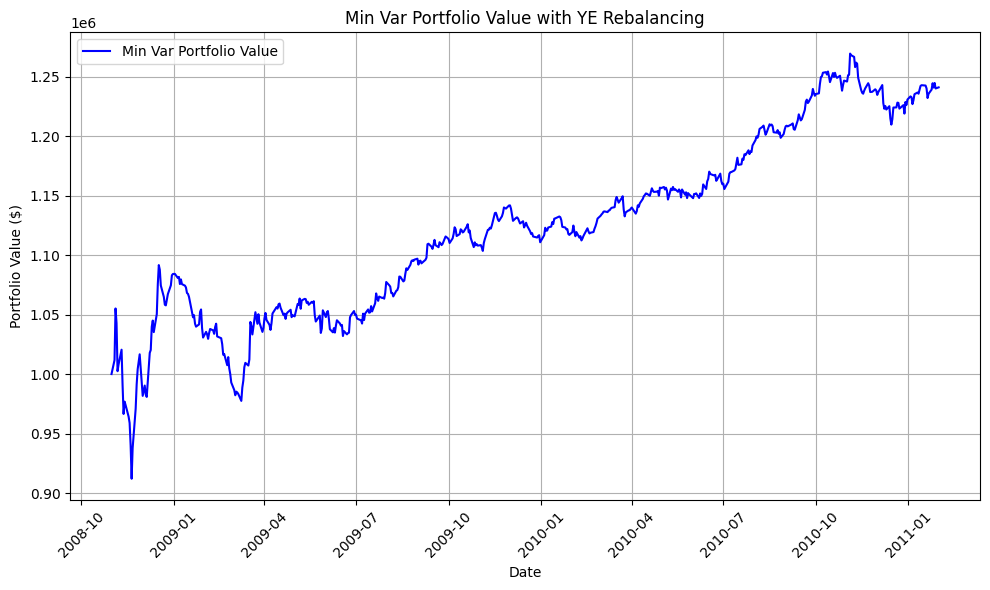

Final Portfolio Value: $1,240,937.76


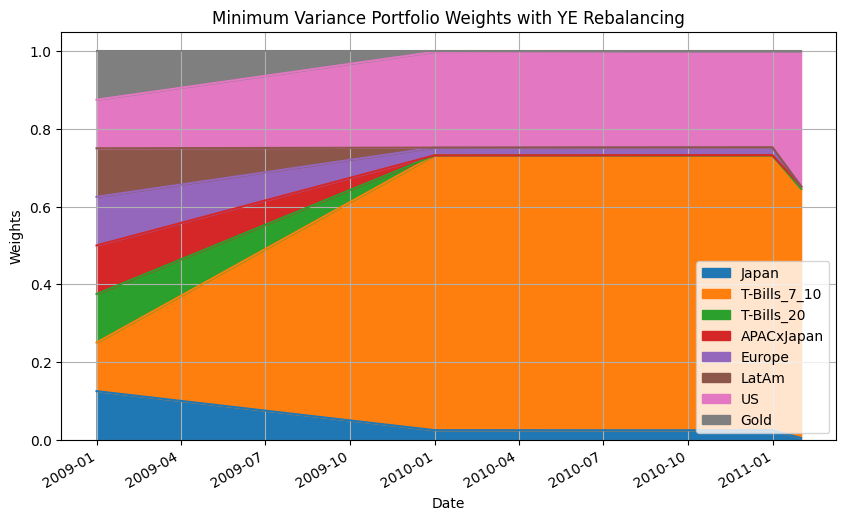

In [7]:
#### Min Var Portfolio Construction #### ver 2.2

# Helper to calculate portfolio variance
def calc_portfolio_variance(w, covariance_matrix):
    # Portfolio variance = w^T * Covariance Matrix * w
    return np.dot(w.T, np.dot(covariance_matrix, w))

# Helper for weight constraint
def total_weight_constraint(w):
    return np.sum(w) - 1  # Total weights must sum to 1

# Portfolio optimization function to minimize variance
def min_variance_optimizer(cov_matrix, w0, bounds, cons):
    #cons = ({'type': 'eq', 'fun': total_weight_constraint},)
    #bounds = [(0, 1) for _ in range(len(returns.columns))]
    # Use scipy's minimize function to find the weights that minimize the portfolio variance
    res = minimize(calc_portfolio_variance, w0, args=(cov_matrix,), bounds=bounds, constraints=cons, method='SLSQP', options = {'ftol':1e-10}) #ftol is a very important variable, test!!!
    return res

# Main function to calculate minimum variance portfolio over time
def min_variance_portfolio(returns, rebalance_frequency, initial_investment=1e6):

    rebal_dates = returns.resample(rebalance_frequency).last().index
    aligned_rebal_dates = returns.index.get_indexer(rebal_dates, method='nearest')
    rebal_dates = returns.index[aligned_rebal_dates]

    portfolio_value = pd.Series(index=returns.index, dtype=float)
    portfolio_value.iloc[0] = initial_investment

    portfolio_weights = pd.DataFrame(index=rebal_dates, columns=returns.columns, dtype=float)

    n_assets = returns.shape[1]
    w0 = np.ones(n_assets) / n_assets  # initial: 1/n
    bounds = [(0, 1) for _ in range(n_assets)]
    cons = ({'type': 'eq', 'fun': total_weight_constraint},)

    if len(rebal_dates) > 0:
        portfolio_weights.iloc[0] = w0

    # 5) Rebalancing loop
    for i in range(len(rebal_dates)):
        this_rebal_date = rebal_dates[i]

        # (A) If not the first rebal date, compute new weights:
        if i > 0:
            lookback_days = 180  # ~180 calendar days (6 months), just an example
            cov_start = this_rebal_date - pd.Timedelta(days=lookback_days)
            cov_data = returns.loc[cov_start:this_rebal_date]

            if cov_data.isna().any().any() or len(cov_data) < 2:
                print(f"Skipping rebal {this_rebal_date} due to insufficient data.")
            else:
                # Optimize min variance
                cov_matrix = cov_data.cov().values
                res = min_variance_optimizer(cov_matrix, w0, bounds, cons)
                if not res.success:
                    print(f"Optimization failed at {this_rebal_date}")
                else:
                    optimal_weights = res.x
                    assert np.isclose(np.sum(optimal_weights), 1), "Weights do not sum to 1."
                    assert all(0 <= w <= 1 for w in optimal_weights), "Weights are out of [0,1] bounds."
                    w0 = optimal_weights
                    portfolio_weights.loc[this_rebal_date] = w0

        if i == 0:
            prev_rebal_date = portfolio_value.index[0]
        else:
            prev_rebal_date = rebal_dates[i - 1]

        daily_index_slice = portfolio_value.index[(portfolio_value.index >= prev_rebal_date) & (portfolio_value.index <= this_rebal_date)]

        for d in range(1, len(daily_index_slice)):
            today = daily_index_slice[d]
            yesterday = daily_index_slice[d - 1]
            daily_ret = (returns.loc[today] * w0).sum()
            portfolio_value.loc[today] = portfolio_value.loc[yesterday] * (1 + daily_ret)

    if len(rebal_dates) > 0:
        final_rebal = rebal_dates[-1]
        daily_index_slice = portfolio_value.loc[final_rebal:].index
        for d in range(1, len(daily_index_slice)):
            today = daily_index_slice[d]
            yesterday = daily_index_slice[d - 1]
            daily_ret = (returns.loc[today] * w0).sum()
            portfolio_value.loc[today] = portfolio_value.loc[yesterday] * (1 + daily_ret)

    return portfolio_value, portfolio_weights

#### Actual Fuction Call ####

rebalance_frequency = 'YE'  # ME = monthly, QE = quarterly, YE = yearly
portfolio_value, portfolio_weights = min_variance_portfolio(returns, rebalance_frequency)

# Plot the portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(portfolio_value, label='Min Var Portfolio Value', color='blue')
plt.title(f'Min Var Portfolio Value with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print(f"Final Portfolio Value: ${portfolio_value.iloc[-1]:,.2f}")

# Plot the portfolio weights over time
portfolio_weights.plot(figsize=(10, 6), kind='area', stacked=True)
plt.title(f'Minimum Variance Portfolio Weights with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Weights')
plt.grid(True)
plt.show()


In [8]:
#### Min Var Portfolio Analytics #### ver 2.2

# 1) Resample to monthly frequency and calculate monthly returns
monthly_portfolio_value_minvar = portfolio_value.resample('ME').ffill()
monthly_returns_minvar = monthly_portfolio_value_minvar.pct_change().dropna()

# 2) Full sample annualized monthly volatility
full_sample_monthly_vol = monthly_returns_minvar.std()
annualized_vol = full_sample_monthly_vol * np.sqrt(12)

# 3) Total return & Geo means
initial_val = portfolio_value.iloc[0]
final_val = portfolio_value.iloc[-1]
total_return_minvar = (final_val - initial_val) / initial_val

n_months = len(monthly_returns_minvar)
geo_avg_monthly_return_minvar = (final_val / initial_val) ** (1 / n_months) - 1
geo_avg_yearly_return_minvar = (1 + geo_avg_monthly_return_minvar) ** 12 - 1

# 5) Sharpe Ratio
arithmetic_monthly_return = monthly_returns_minvar.mean()  # Arithmetic mean of monthly returns
annualized_arithmetic_return = arithmetic_monthly_return * 12  # Annualized arithmetic return
sharpe_ratio_minvar = annualized_arithmetic_return / annualized_vol

# 6) Monthly 99% VaR
VaR_99_minvar = monthly_returns_minvar.quantile(1 - 0.99)

# 7) Print results
print("### Min Var Portfolio Analytics ###")
print(f"Full-sample annualized monthly volatility: {annualized_vol:.4f}")
print(f"Total return: {total_return_minvar * 100:.2f}%")

print(f"Geometric avg monthly return (CAGR basis): {geo_avg_monthly_return_minvar * 100:.2f}%")
print(f"Geometric avg yearly return (CAGR basis): {geo_avg_yearly_return_minvar * 100:.2f}%")

print(f"Sharpe Ratio (Arithmetic Return / Annualized Vol): {sharpe_ratio_minvar:.2f}")
print(f"Monthly 99% Value at Risk (VaR): {VaR_99_minvar:.4f}")


### Min Var Portfolio Analytics ###
Full-sample annualized monthly volatility: 0.0807
Total return: 24.09%
Geometric avg monthly return (CAGR basis): 0.80%
Geometric avg yearly return (CAGR basis): 10.07%
Sharpe Ratio (Arithmetic Return / Annualized Vol): 1.23
Monthly 99% Value at Risk (VaR): -0.0460
